## Lecture 5.4: Binary class Image Classification with Perceptron
### Introduction
- Over the past four weeks we explored various data preprocessing techniques and solved some regression problems using linear and logistic regression models. The other side of the supervised learning paragidm is classification problems.
- To solve such problems we are going to consider image classification as a running example and solving it using `Perceptron()` model

### Imports
What is the first step?.
- Import all the necessary packages. For classification problems, we need to import classes and utilities from `sklearn.linear_model`.
  - This module has implementations for different classification models like `Perceptron, LogisticRegression, svm` and `kvm`
- We also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.

The data preprocessing utilities are imported from `sklearn.preprocessing` modules

In [ ]:
# Common imports
import numpy as np
import os
import io
import warnings

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# To plot pretty figures
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Handwritten Digit Classification
- We are going to use **perceptron classifier** to classify(recognize) given digit images. Since a single perceptron could be only used for binary classification, we consider only two classes in the first half, Eventually we extend it to multi-class setting.


- Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be cast as binary classification problem.


- The first step is to create a dataset that contains the collection of digits(also called examples/samples), written by humans. Then each image should be labelled properly.


- Fortunately, we have a standard benchmark dataset called **MNIST**. Let's import that dataset.

### Data loading and splitting

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
#it returns Data and label as pandas dataframe

The data matrix $X$ and the respective label vector $y$ need to be converted to the numpy array by calling a `to_numpy` method.

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

- Let's get some more information like number of features, number of classes, about the dataset.
- Observe that the labels are string datatype not integers.

In [ ]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'Number of features: {X.shape[1]}')
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of samples: 70000, type: float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


- The MNIST dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.
- However, it is often better to scale the range of features between 0 and 1.
- So we can either use `MinMaxScaler` or `MaxAbsScaler`. They don't make any difference as the image pixels can take only positive values from 0 to 255.

In [ ]:
X = MinMaxScaler().fit_transform(X)
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')

Minimum: 0.0, Maximum: 1.0


### **Data Visualization**
Let's pick up a few images (the images are already shuffled in the dataset) and display them with their respective labels.

As said above, the images are stacked as row vector of size $1 \times 784$ and therefore must be reshaped to the matrix of size $28 \times 28$ to display them properly.

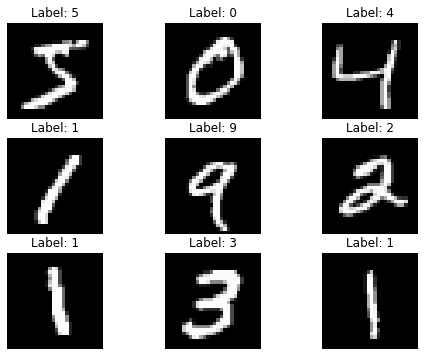

In [ ]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Label: {str(y[index+j])}')
        ax[i,j].set_axis_off()

If you observe closely, you can see there are moderate variations in the appearances of digits (say digit: 1). These matrices are close to sparse (i.e, there are a lot of 0 (black pixels) in the matrix than non-zero pixels).

It is always a good practice to inspect the image pixel values closely and ask some interesting questions like:
1. What is the range of pixel values?
2. Are the pixel values highly correlated?
3. Is the data sparse?
4. What is the range of values that a single pixel(element) can take?
5. Do we need to apply preproceesing methods?

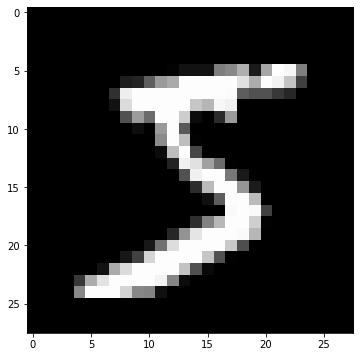

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

### Data Splitting
- Now we know the details such as number of samples, size of each sample, number of features (784), number of classes (targets) about the dataset.
- So let us split the total number of samples into train and test set in the following ratio : 60000/10000 (i.e, 60000 samples in the training set and 10000 samples in the test set)
- Since the samples in the dataset are randomly shuffled, we dont need shuffle it again. Therefore `train_test_split()` can  be skipped.

In [ ]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeeding further, we need to check whether the data is balanced or imbalanced. We can do it buy plotting the distribution of samples in each classes.

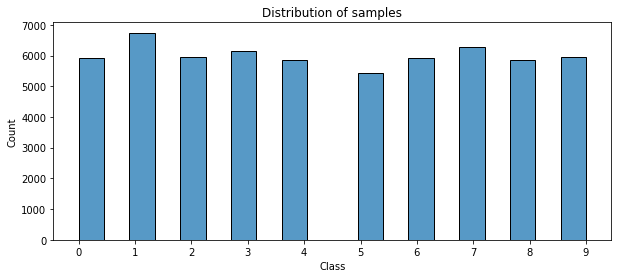

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

### Binary classification : 0-detector

#### Modifying Labels
- Let's start with a simple classification problem, that is binary classification
- Since the original label vector contains 10 classes, we need to modify the number of classes to **2**.
- Therefore, the label **0** will be changed to 1 and all other labels (1-9) will be changed to -1.
- We name the label vectors as `y_train_0` and `y_test_0`.

In [ ]:
# Initialize new variable names with all -1
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find indices of digit 0 image
indx_0 = np.where(y_train == '0') #remember all the original labels are of type str not int.
#use those indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### Sanity check
Let's display the elements of `y_train` and `y_train_0` whether the labels are properly modified.

In [ ]:
print(y_train) # 10 class labels
print(y_train_0) # modified binary labels

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [ ]:
print(np.where(y_train=='0')) # index of label 0's in the original vector y
print(np.where(y_train_0 == 1)) # index of positive class in new vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


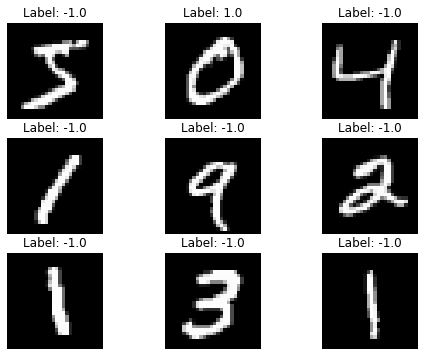

In [ ]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Label: {str(y_train_0[index+j])}')
        ax[i,j].set_axis_off()

#### Baseline Models
Let's quickly construct a baseline model with the following rule (you are free to choose a different rule)
1. Count the number of samples per class
2. The model **always outputs** the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [ ]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [ ]:
base_clf = DummyClassifier(strategy='most_frequent') #there are other strategies

In [ ]:
base_clf.fit(x_train, y_train_0)
print(f'Training accuracy: {base_clf.score(x_train, y_train_0)}')
print(f'Testing accuracy: {base_clf.score(x_test, y_test_0)}')

Training accuracy: 0.9012833333333333
Testing accuracy: 0.902


- Now the reason is obvious. The model would be predicted 54077 sample correctly just by outputing -1 for all input  samples. Therefore the accuracy will be $\frac{54077}{60000} = 90.12\%$


- This is the reason why accuracy is not a good measure.

### Perceptron model

#### Recap (Theory)
Let's quickly recap various components in the general settings:
1. **Training Data**: (features, labels) or ($\mathbf{X}, y$), where label $y$ is a discrete number from a finite set. **Features** in this case are pixel values of an image.
2. **Model**:
   $$\begin{align}
       h_w : y &= \operatorname{g}(\mathbf{w}^T\mathbf{x}) \\
       &= \operatorname{g}(w_0 + w_1x_1+ ... + w_mx_m)
   \end{align}
   $$
   where,
   - $\mathbf{w}$ is a weight vector in $\mathbb{R}^{(m+1)}$ i.e it has components: $\{w_0, w_1, ... , w_m\}$
   - $\operatorname{g}(.)$ is a non-linear activation function given by the signum function:
    $$
    \operatorname{g}(z) = \begin{cases}
    +1 \quad z \ge 0\\
    -1 \quad z \lt 0
    \end{cases}
    $$
3. **Loss function**: Let $\hat{y}^{(i)} \in \{-1,+1\}$ be the prediction from perceptron and $y^{(i)}$ be the actual label for $i$-th example.

The error is
$$
    \ e^{(i)} = \begin{cases}
    0 \quad if \hat{y}^{(i)} = y^{(i)}\\
    -\mathbf{w}^T\mathbf{x}^{(i)}y^{(i)} \quad \text{otherwise} (\text{i.e} \quad \hat{y}^{(i)} \ne y^{(i)})
    \end{cases}
$$
This can be compactly written as:
$$
e^{(i)} = \operatorname{max}(-\mathbf{w}^T\mathbf{x}^{(i)}y^{(i)}, 0) = \operatorname{max}(-h_\mathbf{w}(\mathbf{x}^{(i)})y^{(i)},0)
$$

4. **Optimization**:
   - Perceptron learning algorithm
   1. Initialize $\mathbf{w}^{(i)} = 0$
   2. For each training example $(\mathbf{x}^{(i)}, y^{(i)})$:
      - $\hat{y}^{(i)} = \operatorname{sign}(\mathbf{w}^T\mathbf{x}^{(i)})$ [Calculate the output value]
      - $\mathbf{w}^{(t+1)} := \mathbf{w}^{(t)} + \alpha(y^{(i)} - \hat{y}^{(i)})\mathbf{x}^{(i)}$ [Update the weights]

> Linearly seperable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

#### Parameters of Perceptron class
- Let's quickly take a look into the important parameters of the Perceptron()
```python
class sklearn.linear_model.Perceptron(*, penalty=None, alpha=0.0001,
                                        l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001,
                                        shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, 
                                        early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
                                        class_weight=None, warm_start=False)
```
- Need not pay attention to all the arguments and their default values.


- Internally, the API uses the perceptron loss (i.e, it calls **Hinge(0.0)**, where 0.0 is threshold) and uses SGD to update the weights.


- You may refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) for more details on the `Perceptron` class.


- The other way of deploying perceptron is to use the general `linear_model.SGDClassifier` with `loss='perceptron'`

- The above loss is termed as hard Hinge loss(as scores pass through the sign function) and hence we cant use SGD

- whereas, Sklearn implements hinge-loss with the following definition: $max(0, -wx^iy^i)$ and by default calls sgd to minimize the loss.

#### Instantiation
- Create an instance of binary classifier (bin_clf) and call the `fit` method to train the model.

In [ ]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

#### Training and Prediction
- Call the `fit` method to train the model.
- It would be nice to plot the iteration vs loss curve for training . However, sklearn does not have a direct function to plot it
- Nevertheless, we can workaround this using `partial_fit` method.

In [ ]:
bin_clf.fit(x_train, y_train_0)
print('Dimension of weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('The loss function : {0}'.format(bin_clf.loss_function_))

Dimension of weights w: (1, 784)
Bias: [-108.]
The loss function : <sklearn.linear_model._sgd_fast.Hinge object at 0x7f78066362b0>


Let's make predictions on the train set and then calculate the training accuracy.

In [ ]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training accuracy: ', bin_clf.score(x_train, y_train_0))

Training accuracy:  0.99095


Let's make the predictions on the test set and then calculate the testing accuracy.

In [ ]:
print('Test accuracy:', bin_clf.score(x_test, y_test_0))

Test accuracy: 0.989


#### Displaying few predictions
- Take few images from the testset at random and display it with corresponding predictions
- Plot a few images in a single figure window along with respective **predictions**.

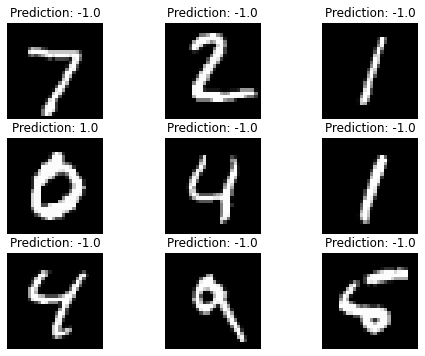

In [ ]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(x_test[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Prediction: {str(y_hat_test_0[index+j])}')
        ax[i,j].set_axis_off()

- Display images of positive classes from the testset along with their predictions

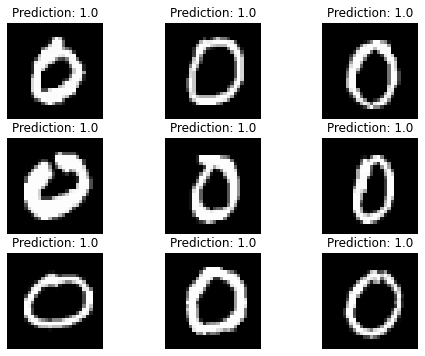

In [ ]:
indx_0 = np.where(y_test_0 == 1)

zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Prediction: {str(zeroLabls[index+j])}')
        ax[i,j].set_axis_off()

It seems that there are significant number of images that are correctly classified. Let's see how many?

In [ ]:
num_missclassified = np.count_nonzero(zeroLabls == -1)
num_correctpred = len(zeroLabls) - num_missclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


- This above score is less than the acccuracy of score of the model.
- Try classifying 5 as positive class and others as negative class

#### Better evaluation metrics
- We know that using the accuracy **alone** to measure performance of the model is not suitable (especially for imbalanced datasets)

#### **Confusion Matrix**

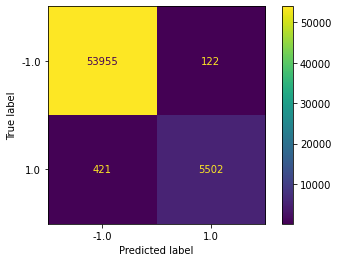

In [ ]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

- Pay attention to the number of FPs and FNs. Suppose we want the classifier to avoid FPs to a good extent irrespective of FNs, how can we achieve it?
- To answer it, let's compute the other metrics which take FPs and FNs into account.

#### Precision and Recall
- We can use the function `classification_report` to compute these parameters. However for the time being let's compute these parameters using the data from the confusion matrix manually

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [ ]:
precision = tp/(tp + fp)
print('Precision:', precision)
recall = tp/(tp+fn)
print('Recall:',recall)
accuracy = (tp + tn)/(tp+tn+fp+fn)
print('Accuracy:',accuracy)

Precision: 0.9783072546230441
Recall: 0.9289211548201924
Accuracy: 0.99095


- The precision is close to 0.98, Despite it, we still want to incease the precision.
- In general, we would like to know whether the model under consideration with the set hyper-parameters is a good one for a given problem.

#### Cross Validation
- Well, to address this, we have to use cross-validation folds and measure the same metrics across these folds for different values of hyper-parameters.
- However, perceptron does not have many hyper-parameters other than learning rate.
- For the moment, we set the learning rate to its default value. Later, we use `GridSearchCV` to find the better value for the learning rate.

In [ ]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0,
                         cv=5,scoring=['precision','recall','f1'],
                         return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.10387802, 2.30673194, 1.6217885 , 1.55739355, 1.99612784]),
 'score_time': array([0.0482564 , 0.04674745, 0.04475832, 0.04635143, 0.05024219]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


**Note**:
- The perceptron estimator passed an argument to the function `cross_validate` is internal cloned `num_fold(cv=5)` times and fitted independently on each fold.(You can check this by setting `warm_start=True`).
- Compute the average and std of scores for all three metrics, on (k=5) folds to measure the generalization.

In [ ]:
print('f1,          avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(), scores['test_f1'].std()))
print('precision,   avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(), scores['test_precision'].std()))
print('recall,      avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(), scores['test_recall'].std()))

f1,          avg:0.94, std:0.013
precision,   avg:0.96, std:0.01
recall,      avg:0.92, std:0.03


- Let's pick up the first estimator returned by the cross-validate function
- So we can hope that the model might perform well on test data. Let's check that out.

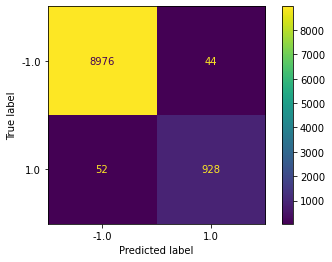

In [ ]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0, values_format='.5g')

In [ ]:
print('Precision %.2f'%precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


**Way-2 for Generalization**
- There is an another approach of getting labels via cross-validation and using to measure the generalization

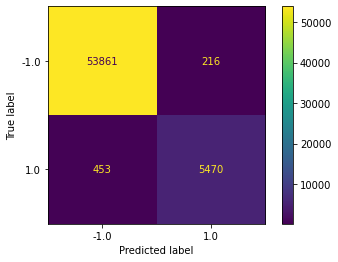

In [ ]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv=5)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp + fp)
print('Precision:', precision)
recall = tp/(tp+fn)
print('Recall:',recall)
accuracy = (tp + tn)/(tp+tn+fp+fn)
print('Accuracy:',accuracy)

Precision: 0.9620119591980303
Recall: 0.9235184872530812
Accuracy: 0.98885


- Compare the precision and recall score obtained by the above method with that of the previous method (that is using `cross_validate` method)
- Finally, we can print all these scores using `classification_report` function

In [ ]:
print('Precision %.2f'%precision_score(y_train_0, y_hat_train_0))
print('Recall %.2f'%recall_score(y_train_0, y_hat_train_0))
print('-'*50)
print(classification_report(y_train_0, y_hat_train_0))

Precision 0.96
Recall 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### Precision-Recall Tradeoff
- Often time we need to make a tradeoff between precision and recall scores of the model.
- It depends on problem at hand
- It is important to note that we **should not pass** the **predicted labels** as input to `precision_recall_curve` function, instead we need to pass the probability scores or the output from the decision function.
- The `Perceptron()` class contains a `decision_function` method. Therefore we can make use of it.
- Then internally the decision scores are sorted **tps** and **fps** will be computed by changing the threshold from index[0] to index[-1]
-Lets compute these scores from the decision function

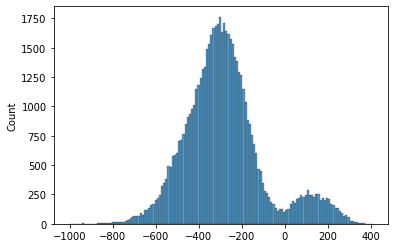

In [ ]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

Can you think why there are so many negative values than the positives?
Class Imbalance
- Suppose threshold takes the values of -600, then all the samples having score greater than -600 is set to 1 (Positive label) and less than it is set to -1 (Negative label).
- Therefore, the number of False positives will be increased. This will in turn reduce the precision score to a greater extent.
- On the other hand, if the threshold takes the values of say, 400. Then the number of false negatives will be increased and hence the recall score will reduce to a greater extent

Let's see it in action

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

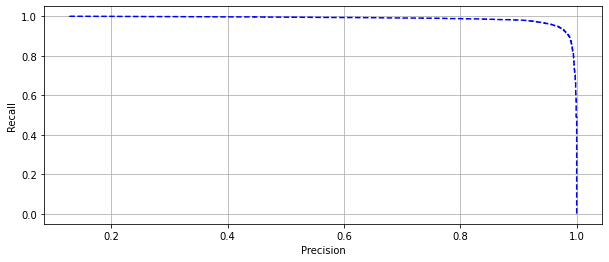

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(precisions[:-1], recalls[:-1], 'b--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

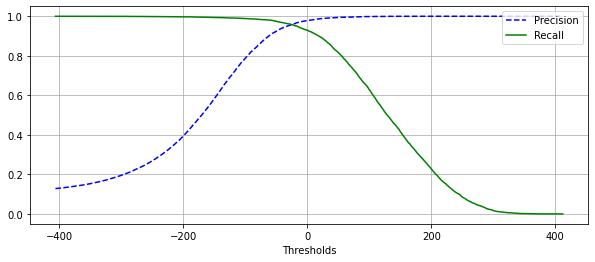

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, precisions[:-1], 'b--',label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Thresholds')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#get the index of threshold around zero
idx_th = np.where(np.logical_and(thresholds>0, thresholds<1))
print('Precision for zero threshold:', precisions[idx_th[0][0]])

Precision for zero threshold: 0.9783072546230441


- **Here is the solution** to the question how can we increase the precision of the classifier by comprimising the recall, we can make use of the above plot.


In [ ]:
def predict(y_scores):
    y_hat = np.where(y_scores>20,1,-1) # shifted signum function
    return y_hat

In [ ]:
y_hat_train_0_thrsh = predict (y_scores)
print(classification_report(y_train_0, y_hat_train_0_thrsh))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.99      0.90      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.95      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### ROC curve

In [ ]:
from sklearn.metrics import roc_curve

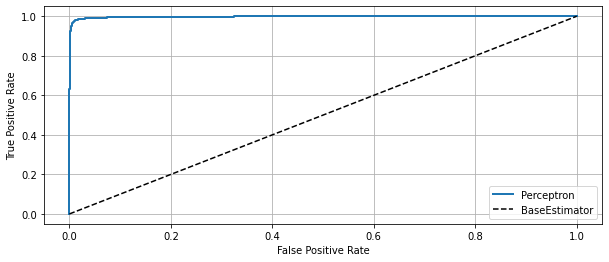

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0,1],[0,1],'k--', label='BaseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

### Warm Start vs Cold Start


#### Cold Start
- If we execute the `fit` method of `bin_clf` repeatedly, we get the same score for both training and testing accuracy.
- This because everytime the `fit` method is called, the model weights are initialized to the same values. Therefore, we obtain the same score.
- This is termed as **cold start**. Let's execute the cell 4 times and observe the score.

In [ ]:
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy:', bin_clf.score(x_train, y_train_0))
print('Test Accuracy:', bin_clf.score(x_test, y_test_0))

Training Accuracy: 0.99095
Test Accuracy: 0.989


#### Warm Start
- Setting `warm_start=True` retains the weight values of the model after `max_iter` and hence produce different results for each execution.
- Warm starting is useful in many ways. It helps us train the model by initializing the weight values from the previous state. So we can pause the training and resume it whenever we get the resource for computation.
- Of course, it is not required for simple models like perceptron and for a small dataset like MNIST.
- In this notebook, we use this feature to plot the iteration vs loss curve.
- Let's execute the following lines of code 4 times and observe how the training accuracy changes for each execution.

In [ ]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True)

In [ ]:
bin_clf_warm.fit(x_train, y_train_0)
print('Training accuracy: ', bin_clf_warm.score(x_train, y_train_0))

Training accuracy:  0.99095


## Lecture 5.5: Multi class Image Classification with Perceptron 


### Multiclass Classifier (One vs All)
- We know that the perceptron is a binary classifier. However, MNIST dataset contains 10 classes. Then how can we extend the idea to handle multi-class problems?
- **Solutions**: Combine multiple binary classifiers and devise a suitable scoring metric.
- Sklearn makes it extremely easy without modifying a single line of code that we have written for the binary classifier.
- Sklearn does this by counting a number of unique elements (10 in this case) in the label vector `y_train` and converting labels using `LabelBinarizer` to fit each binary classifier

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [ ]:
clf = Perceptron(random_state=1729)

In [ ]:
#  let's use label binarizer just to see the encoding.
y_train_ovr = LabelBinarizer().fit_transform(y_train) # setting sparse_output = True in LabelBinarizer() improves efficiency
for i in range(10):
    print(f'{y_train[i]}: {y_train_ovr[i]}')

5: [0 0 0 0 0 1 0 0 0 0]
0: [1 0 0 0 0 0 0 0 0 0]
4: [0 0 0 0 1 0 0 0 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
9: [0 0 0 0 0 0 0 0 0 1]
2: [0 0 1 0 0 0 0 0 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
3: [0 0 0 1 0 0 0 0 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
4: [0 0 0 0 1 0 0 0 0 0]


- The `y_train_ovr` will be of size $60000 × 10$
- The first column will be (binary) label vector for 0-detector and the next one for 1-detector and so on

In [ ]:
clf.fit(x_train, y_train)

Perceptron(random_state=1729)

- What actually happend internally was that the API automatically created 10 binary classifiers, converted labels to binary sparse matrix and trained them with the binarized labels.
- During the inference time, the input will be passed through all these 10 classifiers and the highest score among the output from the classifiers will be considered predicted class
- To see it in action, let's execute the following lines of code.

In [ ]:
print(f'Shape of Weight matrix: {clf.coef_.shape} and bias vector: {clf.intercept_.shape}')

Shape of Weight matrix: (10, 784) and bias vector: (10,)


- So it is matrix of size $10 \times 784$ where each row represents the weights for a single binary classifier.
- Important difference to note is that there are no signum function assosciated with perceptron.
- The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [ ]:
scores = clf.decision_function(x_train[6].reshape(1, -1))
print(scores)
print('The predicted class: ', np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]
The predicted class:  1


In [ ]:
print('Predicted output', clf.predict(x_train[6].reshape(1,-1)))

Predicted output ['1']


In [ ]:
# get the prediction for all the training examples
y_hat = clf.predict(x_train)

In [ ]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



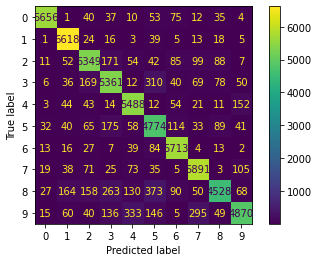

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat,values_format='.5g') #it returns a matplotlib plot object
plt.show()

- What are all the insights we could infer from the above figure?
- Digit 2 is often confused with digit 3

### Making a pipeline
- Let's create a pipeline to keep the code compact.
- Recall that, the MNIST dataset is clean and hence doesnt require preprocessing.
- The one potential technique we may use is scale features within the range(0,1)
- It is **not** similar to scaling down the range values between 0 and 1.

In [ ]:
# create a list of named tuples
estimators = [('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())]
pipe = Pipeline(estimators)

In [ ]:
pipe.fit(x_train, y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

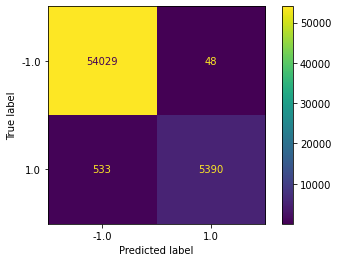

In [ ]:
y_hat_train_0 = pipe.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

### Iteration vs Loss Curve
The other way of **Plotting iteration vs Loss curve** with `partial_fit` method

In [ ]:
iterations = 100
bin_clf1 = Perceptron(max_iter=1000, random_state=2094)
Loss_clf1 = []
for i in range(iterations):
    bin_clf1.partial_fit(x_train, y_train_0, classes=np.array([-1,1]))
    y_hat_0 = bin_clf1.decision_function(x_train)
    Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

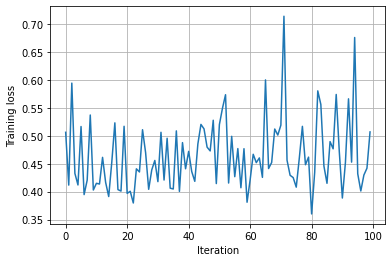

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

### GridSearchCV
- So far we didn't do any hyperparameter tuning. We accepted the default value for learning rate of Perceptron class.
- Now let us search for a better learning rate using `GridSearchCV`.
- No matter what the learning rate is, the loss will never converge to zero as classes are not linearly separable.

In [ ]:
scoring = make_scorer(hinge_loss, greater_is_better=False)
lr_grid = [1/2**n for n in range(1,6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid={'eta0':lr_grid},scoring=scoring, cv=5)
bin_clf_gscv.fit(x_train, y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [ ]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.38710709, 1.24280896, 1.06078939, 0.89691143, 0.8232986 ]),
 'mean_score_time': array([0.03171921, 0.02215948, 0.01746993, 0.01811504, 0.01746025]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5], dtype=int32),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.

As you can see the best learning rate is 0.125

In [ ]:
iterations = 100
best_bin_clf = Perceptron(max_iter=1000, random_state=2094,eta0=0.125)
Loss = []
for i in range(iterations):
    best_bin_clf.partial_fit(x_train, y_train_0, classes=np.array([-1,1]))
    y_hat_0 = best_bin_clf.decision_function(x_train)
    Loss.append(hinge_loss(y_train_0, y_hat_0))

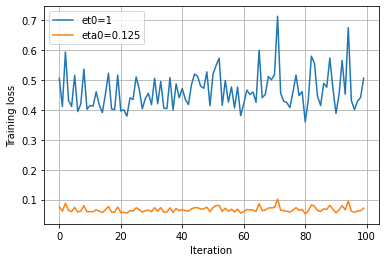

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1, label='et0=1')
plt.plot(np.arange(iterations), Loss, label="eta0=0.125")
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend()
plt.show()

Well, instead of instantiating a Perceptron class with a new learning rate and re-train the model, we could simply get the `best_estimator_` from the `GridSearchCV` as follows:

In [ ]:
best_bin_clf = bin_clf_gscv.best_estimator_

In [ ]:
y_hat_train_0 = best_bin_clf.predict(x_train)
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99     54077
         1.0       0.95      0.95      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Compare the classification report when `eta0=1`

### Visualizing weight Vectors
It will be interesting to look at the samples which are misclassified as False Positives(i.e images that are not zero but classified as zero) and come up with a possible reasons.

In [ ]:
#Repeating the code for readablility
bin_clf = Perceptron(max_iter=100)
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)

In [ ]:
# find the index of false positives samples
idx_n = np.where(y_train_0 == -1) #index of true -ve samples
idx_pred_p = np.where(y_hat_train_0 == 1) #index of predicted positive samples
idx_pred_n = np.where(y_hat_train_0 == -1) #index of predicted negative samples
idx_fp = np.intersect1d(idx_n, idx_pred_p)
idx_tn = np.intersect1d(idx_n, idx_pred_n)

In [ ]:
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(3):
    index =  idx_offset + i
    for j in range(3):
        ax[i,j].imshow(x_train[idx_fp[index+j]].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'GT: {str(y_train_0[idx_fp[index+j]])}, Pr: {str(y_hat_train_0[idx_fp[index+j]])}')
        ax[i,j].set_axis_off()

We can do some reasoning if we look into what the perceptron is actually learning about the digit **0** by visualizing the weight values after the training.

In [ ]:
from matplotlib.colors import Normalize

In [ ]:
w = bin_clf.coef_
w_matrix = w.reshape(28,28)
fig = plt.figure()
plt.imshow(w_matrix, cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

In [ ]:
activation = w * x_train[idx_fp[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_fp[0]].reshape(28,28), cmap='gray')
plt.colorbar()

#lin_out[lin_out<0] = 0 # Just set the values less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
#input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)

In [ ]:
activation = w * x_train[idx_tn[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_tn[0]].reshape(28,28), cmap='gray')
plt.colorbar()

#lin_out[lin_out<0] = 0 # Just set the values less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
#input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)